### Import the libraries

In [51]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Dense,Flatten,Reshape,Dropout,Dropout,MaxPooling1D,Conv1D,GlobalMaxPooling1D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical,plot_model

from tfltransfer import bases
from tfltransfer import heads
from tfltransfer import optimizers
from tfltransfer.tflite_transfer_converter import TFLiteTransferConverter

from sklearn.metrics import confusion_matrix, classification_report

### Preprocess data

In [4]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/types/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, trainy, testX, testy

### Load data

In [14]:
# call a load_dataset function
trainX, trainy, testX, testy = load_dataset()
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


### Build the CNN

In [16]:
def get_model():
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    input_shape = Input(shape=(n_timesteps,n_features))
    kernel_size = 3
    pool_size = 2
    l2_rate = 1e-4
    learning_rate = 1e-4
    num_classes = 6
    
    x = Conv1D(32, kernel_size = 24, 
            activation = "relu", 
            padding = "valid", 
            kernel_regularizer = l2(l2_rate))(input_shape)
    x = Dropout(0.1)(x)
    
    x = Conv1D(64, kernel_size = 16, 
            activation = "relu", 
            padding = "valid", 
            kernel_regularizer = l2(l2_rate))(x)
    x = Dropout(0.1)(x)
    
    x = Conv1D(96, kernel_size = 8, 
            activation = "relu", 
            padding = "valid", 
            kernel_regularizer = l2(l2_rate))(x)
    x = Dropout(0.1)(x)
    
    x = Conv1D(128, kernel_size = 4, 
            activation = "relu", 
            padding = "valid", 
            kernel_regularizer = l2(l2_rate),
            name="encoder")(x)
    x = GlobalMaxPooling1D()(x) 
    output = Dense(num_classes, activation = "softmax")(x)
    
    model = Model(input_shape, output)
    model.compile(optimizer = Adam(learning_rate), 
                loss = "categorical_crossentropy",
                metrics = ["categorical_accuracy"])
    
    plot_model(model, show_shapes=True, to_file='multichannel.png')

    return model

### Train the CNN on the Training set

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten, Dense

epochs = 30
batch_size = 32
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

model = get_model()

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs = epochs, batch_size = batch_size, verbose = 2)
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

Epoch 1/30
230/230 - 15s - loss: 0.8361 - categorical_accuracy: 0.7300 - val_loss: 0.4393 - val_categorical_accuracy: 0.8717
Epoch 2/30
230/230 - 12s - loss: 0.2162 - categorical_accuracy: 0.9328 - val_loss: 0.3826 - val_categorical_accuracy: 0.8802
Epoch 3/30
230/230 - 13s - loss: 0.1706 - categorical_accuracy: 0.9455 - val_loss: 0.3419 - val_categorical_accuracy: 0.8901
Epoch 4/30
230/230 - 13s - loss: 0.1552 - categorical_accuracy: 0.9472 - val_loss: 0.3412 - val_categorical_accuracy: 0.8945
Epoch 5/30
230/230 - 12s - loss: 0.1447 - categorical_accuracy: 0.9508 - val_loss: 0.3366 - val_categorical_accuracy: 0.9002
Epoch 6/30
230/230 - 11s - loss: 0.1409 - categorical_accuracy: 0.9502 - val_loss: 0.3383 - val_categorical_accuracy: 0.8992
Epoch 7/30
230/230 - 12s - loss: 0.1361 - categorical_accuracy: 0.9536 - val_loss: 0.3042 - val_categorical_accuracy: 0.9043
Epoch 8/30
230/230 - 13s - loss: 0.1329 - categorical_accuracy: 0.9550 - val_loss: 0.3053 - val_categorical_accuracy: 0.9043


### Plot accuracy and loss on the training and validation datasets over training epochs

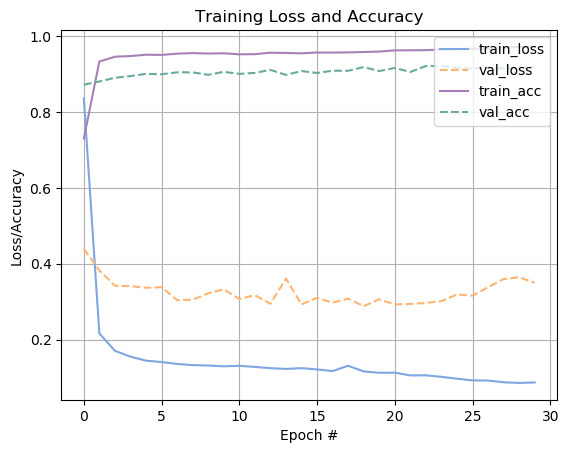

In [18]:
plt.show()
plt.style.use('default')
plt.grid(True)
plt.plot(history.history['loss'],'#7EA6E0')
plt.plot(history.history['val_loss'],color = '#FFB570', linestyle='dashed')
plt.plot(history.history['categorical_accuracy'],'#A680B8')
plt.plot(history.history['val_categorical_accuracy'], color = '#67AB9F', linestyle='dashed')
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss', 'train_acc', 'val_acc'], loc='upper right')
plt.show()

### Show a classification report

In [29]:
target_names = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying']
preds = np.round(model.predict(testX),0)
print(classification_report(testy, preds,target_names=target_names))

              precision    recall  f1-score   support

     Walking       1.00      0.93      0.96       496
    Upstairs       0.93      0.94      0.94       471
  Downstairs       0.90      1.00      0.95       420
     Sitting       0.84      0.84      0.84       491
    Standing       0.86      0.85      0.85       532
      Laying       0.99      0.95      0.97       537

   micro avg       0.92      0.92      0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947
 samples avg       0.92      0.92      0.92      2947



### Build a confusion matrix

In [39]:
categorical_test_labels = pd.DataFrame(testy).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_preds)
print(cm)

[[466   4  26   0   0   0]
 [  3 444  19   0   5   0]
 [  0   0 420   0   0   0]
 [  2   3   0 411  70   5]
 [  0   0   0  79 453   0]
 [  0  25   1   0   0 511]]


In [40]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title="Confusion matrix",
   cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" 
                 if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label") 
    plt.set_cmap('GnBu')

Normalized confusion matrix


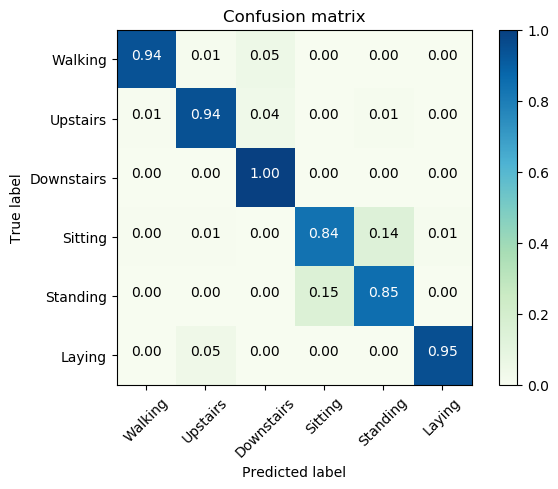

In [43]:
# call a plot_confusion_matrix function
plot_confusion_matrix(cm, ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying'], normalize=True)

### Save the model

In [44]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


### Save the tflite_model

In [45]:
save_model(model, tflite_model, 
            include_optimizer = False, 
            save_format="tf")

INFO:tensorflow:Assets written to: par_model/assets


### Config the on-device model

In [ ]:
tflite_model = "par_model"
tflite_ondevice_model = "par_ondevice"

num_classes = 6
learning_rate = 1e-4
batch_size = 16
l2_rate = 1e-4
hidden_units = 128
input_shape = model.output_shape[1:]

base = bases.SavedModelBase(tflite_model)

head = Sequential([
    Flatten(input_shape=input_shape),
    Dense(units=hidden_units,
        activation="relu",
        kernel_regularizer=l2(l2_rate)),
    Dense(units=num_classes, 
        activation="softmax",
        kernel_regularizer=l2(l2_rate)),
])

head.compile(loss="categorical_crossentropy", optimizer="adam")

converter = TFLiteTransferConverter(num_classes, 
            base,
            heads.KerasModelHead(head),
            optimizers.SGD(learning_rate),
            train_batch_size=batch_size) 

converter.convert_and_save(tflite_ondevice_model)